# CaF MOT

This example covers calculating the forces in a standard, six-beam CaF MOT.
The goal is to reproduce the figures in M.R. Tarbutt and T.C. Steimle, “Modeling magneto-optical trapping of CaF molecules” *Physical Review A* **92** 053401 (2015); http://dx.doi.org/10.1103/PhysRevA.92.053401

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp

## Define the problem

### Define the Hamiltonian

The spectroscopic numbers for the ground state come from W.J. Childs, G.L. Goodman, and L.S. Goodman, "Precise determination of the $v$ and $N$ dependence of the spin-rotation and hyperfine interactions in the CaF X$^2\Sigma_{1/2}$ ground state", *Journal of Molecular Spectroscopy* **86** 365 (1981); https://doi.org/10.1016/0022-2852(81)90288-5.

In [2]:
Gamma = 8.3 # MHz

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    Lambda=0, S=1/2, N=1, I1=1/2, B=0, gamma=39.65891/Gamma, q=0, 
    b=109.1893/Gamma, c=40.1190/Gamma, CI=2.876e-2/Gamma, q0=0, q2=0,
    gS=2.0023193043622, gI=0.,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    Lambda=1, J=1/2, S=1/2, I1=1/2, P=+1, Ahfs=2.4/Gamma, gJ=2*-0.021, gI=0., p=0, q=0,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I1=1/2, S=1/2, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq)

### Set up the other parameters

There are some small things to consider.  First, they use total power in each
beam rather than saturation intensity.  In the paper, they assume unclipped
Gaussian beams of $w=12$ mm $1/e^2$ radius and use powers of 5, 15, 40 and 100 mW.
The relationship between intensity $I$ and power $P$ is given by $I = 2 P/pi w^2$.
Moreover, $I_{\rm sat}$ = $2 \pi^2 \hbar c \Gamma/\lambda^2$.  They also assume $20$ G/cm.
Given that we define $\mu_B$ above in terms of linewidth/G, it should be just as
simple as plugging in 2 G/mm in the magField.

In [3]:
omega = 2*np.pi*(cts.c/606e-9)
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)
#print("I_sat = ", Isat*1e-4*1e3)

# Make the magnetic field (2 G/mm):
magField = pylcp.quadrupoleMagneticField(2)

# A litle helper function to make the MOT:
def six_beam_CaF_MOT(s, det):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<3:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)+det, pol=+1,
                beam_type=pylcp.infinitePlaneWaveBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)+det, pol=-1,
                beam_type=pylcp.infinitePlaneWaveBeam
                )

    return laserBeams

## Reproduce Fig. 3

Note that we do not use Gaussian beams, so there will probably be some disagreement out at large $x$:

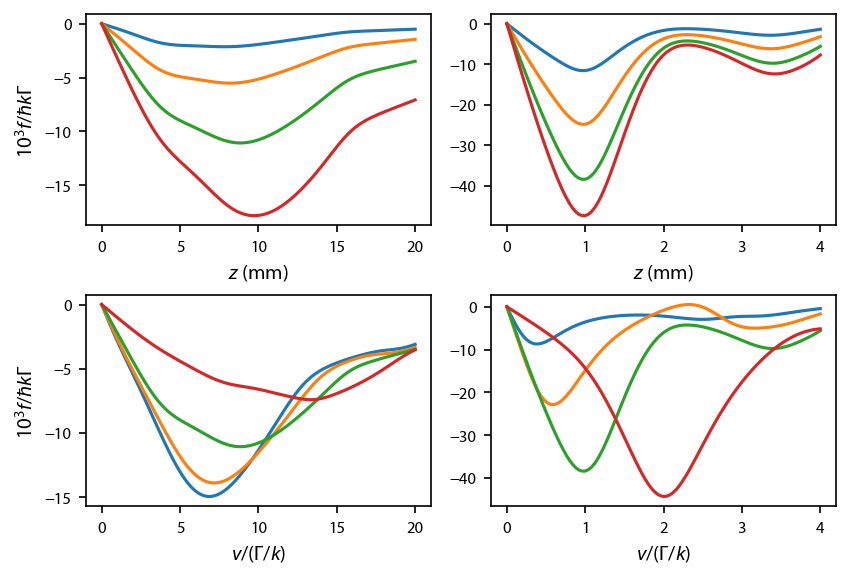

In [4]:
# The detunings used in the PRAs:
dets = np.array([-0.25, -0.5, -1, -2])
P = np.array([0.005, 0.015, 0.040, 0.1])
intensities = 2.*P/(np.pi*0.012**2)/Isat

# Make the axis:
z = np.linspace(1e-10, 20., 101)
v = np.linspace(0., 4., 101)

# Start the figure:
fig, ax = plt.subplots(2, 2, figsize=(6.25, 4), num="Forces in CaF MOT")
for ii, intensity in enumerate(intensities):
    laserBeams = six_beam_CaF_MOT(intensity, dets[2])
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[0, 0].plot(z, 1e3*trap.profile['Fz'].F[2], color='C{0:d}'.format(ii))
    ax[0, 1].plot(v, 1e3*trap.profile['Fv'].F[2], color='C{0:d}'.format(ii))

for ii, det_i in enumerate(dets):
    laserBeams = six_beam_CaF_MOT(intensities[2], det_i)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[1, 0].plot(z, 1e3*trap.profile['Fz'].F[2], color='C{0:d}'.format(ii))
    ax[1, 1].plot(v, 1e3*trap.profile['Fv'].F[2], color='C{0:d}'.format(ii))
    
ax[0, 0].set_ylabel('$10^3 f/\hbar k \Gamma$')
ax[1, 0].set_ylabel('$10^3 f/\hbar k \Gamma$')

for ax_i in ax[0, :]:
    ax_i.set_xlabel('$z$ (mm)')
for ax_i in ax[1, :]:
    ax_i.set_xlabel('$v/(\Gamma/k)$')
    
fig.subplots_adjust(hspace=0.33, wspace=0.175)

## Simulate the two color MOT

This reproduces Fig. 4.

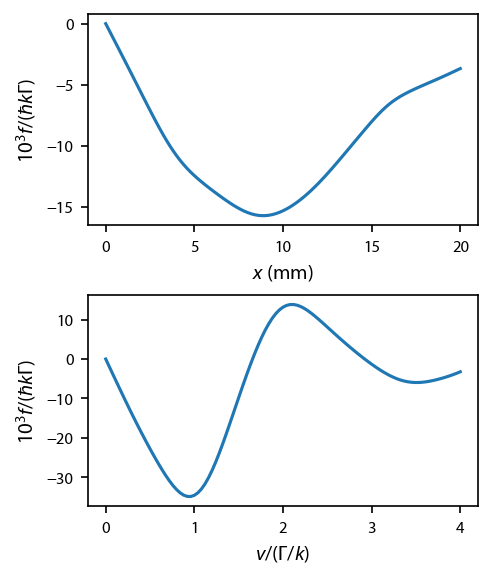

In [5]:
laserBeams = six_beam_CaF_MOT(intensities[2], dets[2])
laserBeams += pylcp.conventional3DMOTBeams(
    s=intensities[2], delta=(E_A[-1] - E_X[0]) + 2, pol=-1
    )

fig, ax = plt.subplots(2, 1, figsize=(3.25, 4),
                       num="Forces in two-color CaF MOT")

trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
trap.generate_force_profile(
    [np.zeros(z.shape), np.zeros(z.shape), z],
    [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
    name='Fz')
trap.generate_force_profile(
    [np.zeros(v.shape), np.zeros(v.shape), 1e-3*np.ones(v.shape)],
    [np.zeros(v.shape), np.zeros(v.shape), v],
    name='Fv')
ax[0].plot(z, 1e3*trap.profile['Fz'].F[2])
ax[1].plot(v, 1e3*trap.profile['Fv'].F[2])

ax[0].set_xlabel('$x$ (mm)')
ax[0].set_ylabel('$10^3 f/(\hbar k \Gamma)$')
ax[1].set_xlabel('$v/(\Gamma/k)$')
ax[1].set_ylabel('$10^3 f/(\hbar k \Gamma)$')

fig.subplots_adjust(hspace=0.33)